In [163]:
import pymongo 
import matplotlib
import string
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [164]:
# Connecting to MongoDB 
client = pymongo.MongoClient("mongodb://localhost:27017")
db = client["final_project"]
collection = db["project1"]

In [165]:
# TEST: Defining and executing a query to obtain all dates and tweets
query = {}
projection = {'tweet': 1, 'date': 1, '_id': 0}
tweets = collection.find(query, projection)

In [166]:
# Defining and executing a query to obtain an aggregated list of tweets per year 
pipeline = [{'$project': {
            'tweet': 1,
            'year': {'$year': {'$dateFromString': {'dateString': '$date'}}}}},
    {'$group': {
            '_id': '$year',
            'tweets': {'$push': '$tweet'},
            'count': {'$sum': 1}}},
    {'$sort': {'_id': 1}}]

results = list(collection.aggregate(pipeline))

In [29]:
for result in results: 
    tweets = result['tweets'] 
    
    processed_tweets = []
    for tweet in tweets: 
        s = tweet.lower()
        s = s.translate(str.maketrans("", "", string.punctuation))
        s = re.sub(r'\d+', '', s)
        
        # Append the processed string to the output list
        processed_tweets.append(s)
    
     # Replace the original tweets with the processed tweets
    result['tweets'] = processed_tweets
    
print(results)


[{'_id': 2008, 'tweets': ['washington reuters  growth in the us economy slowed abruptly in the fourth quarter as consumers curbed spending and homebuilding pl ', 'bush says economy resilient despite slim gdp growth  httptinyurlcomzub', 'washington reuters  growth in the us economy slowed abruptly in the fourth quarter as consumers curbed spending and homebuilding pl ', 'washington reuters  growth in the us economy slowed abruptly in the fourth quarter as consumers curbed spending and homebuilding pl ', 'washington reuters  growth in the us economy slowed abruptly in the fourth quarter as consumers curbed spending and homebuilding pl ', 'washington reuters  growth in the us economy slowed abruptly in the fourth quarter as consumers curbed spending and homebuilding pl ', 'washington reuters  growth in the us economy slowed abruptly in the fourth quarter as consumers curbed spending and homebuilding pl ', 'washington reuters  growth in the us economy slowed abruptly in the fourth quarter 

In [167]:
analyzer = SentimentIntensityAnalyzer()

# defining an empty dictionary 
year_sentiment = {}

for result in results:
    # define year and list of tweets 
    year = result['_id']
    tweets = result['tweets'] 
    
    # use VADER to keep track of avg compound scores for a given year 
    sentiment_scores = [analyzer.polarity_scores(tweet)['compound'] for tweet in tweets] 
    year_sentiment[result['_id']] = (sum(sentiment_scores)/len(sentiment_scores)) * 100

# Create a DataFrame from the dictionary
yearly_df = pd.DataFrame(list(year_sentiment.items()), columns=['Year', 'Score'])

# Print the resulting DataFrame
print(yearly_df)

    Year      Score
0   2008  32.328816
1   2009  32.898673
2   2010  36.427416
3   2011  34.133871
4   2012  34.558528
5   2013  34.527489
6   2014  35.784848
7   2015  39.225281
8   2016  36.310490
9   2017  37.935008
10  2018  37.495524
11  2019  32.597638
12  2020  29.861182
13  2021  36.743138
14  2022  28.147584


In [168]:
sentiment_list = []

for result in results:
    # define year and list of tweets 
    year = result['_id']
    tweets = result['tweets'] 
    tweet_text = ' '.join(tweets)
    
    scores = analyzer.polarity_scores(tweet_text)
    
    # Extract the negative, positive, and neutral scores from the dictionary
    negative_score = scores["neg"]
    positive_score = scores["pos"]
    neutral_score = scores["neu"]

    # Calculate the percentage of negative, positive, and neutral sentiment in the text
    total_score = negative_score + positive_score + neutral_score
    negative_percentage = (negative_score / total_score) * 100
    positive_percentage = (positive_score / total_score) * 100
 
    # Create a dictionary with the year, positive and negative percentage
    sentiment_dict = {
        'year': year,
        'negative_percentage': - negative_percentage,
        'positive_percentage': positive_percentage,
        'score': (positive_score - negative_score) * 100}
    sentiment_list.append(sentiment_dict)

# Create a DataFrame from the list of dictionaries
df = pd.DataFrame(sentiment_list)

print(df)

    year  negative_percentage  positive_percentage  score
0   2008            -8.300000            24.100000   15.8
1   2009            -8.000000            23.600000   15.6
2   2010            -7.300000            25.700000   18.4
3   2011           -10.600000            25.100000   14.5
4   2012            -7.900000            25.700000   17.8
5   2013            -8.108108            26.426426   18.3
6   2014            -7.507508            25.925926   18.4
7   2015            -6.000000            26.200000   20.2
8   2016            -7.807808            26.926927   19.1
9   2017            -8.200000            25.600000   17.4
10  2018            -8.800000            21.000000   12.2
11  2019           -10.100000            20.800000   10.7
12  2020            -9.509510            19.119119    9.6
13  2021            -8.500000            20.200000   11.7
14  2022           -10.800000            19.600000    8.8


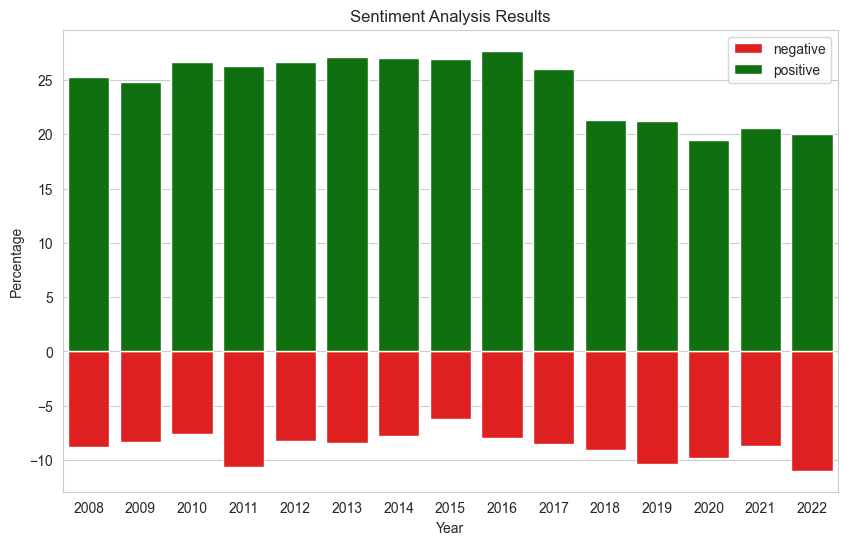

In [149]:
sns.set_style("whitegrid")
fig, ax1 = plt.subplots(figsize=(10, 6))

# define colors 
colors = ["red", "green"]
custom_palette = sns.set_palette(sns.color_palette(colors))

# Create the stacked bar chart using Seaborn
sns.barplot(data=df, x='year', y='negative_percentage', color='red', ax=ax1, label='negative')
sns.barplot(data=df, x='year', y='positive_percentage', color='green', ax=ax1, label='positive')

#sns.lineplot(data=df, x='year', y='score', color='black', ax=ax1)

# Set the x-axis limits to match
ax.set_xlim(df['year'].min(), df['year'].max())

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Percentage')
plt.title('Sentiment Analysis Results')
plt.legend()

# Show the plot
plt.show()

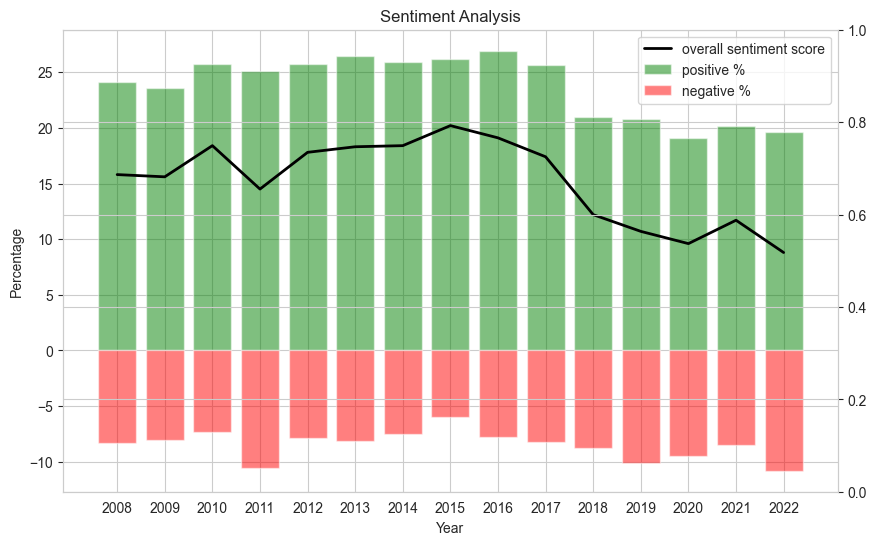

In [169]:
fig, ax1 = plt.subplots(figsize=(10,6))
ax2 = ax1.twinx()

# Create barplot with % vs year
ax1.bar(df['year'], df['positive_percentage'], color='green', alpha=0.5, label = 'positive %')
ax1.bar(df['year'], df['negative_percentage'], color='red', alpha=0.5, label = 'negative %')

# Set labels and titles
ax1.set_xlabel('Year')
ax1.set_ylabel('Percentage')
ax1.set_title('Sentiment Analysis')

# Create lineplot with score vs year
ax1.plot(df['year'], df['score'], color='black', linewidth=2, label = 'overall sentiment score')

# Set x-axis ticks
plt.xticks(df['year'])
ax1.legend()
# Show the plot
plt.show()